# General Routes

This notebooks calculates the cycling potential of any route.

It uses the Open Street Map API to get the coordinates of a given adress, and integrates with Graph Hopper API to generate the bicycle routes to connect the origin and destination

It also generate a json file that can be read in a web-page to visualize the trip. 

In [1]:
import requests
import urllib.parse
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import ast
import matplotlib.pyplot as plt
from ipywidgets import interact_manual, widgets, fixed

import saopaulo.cycling_potential as cp
from bikescience.slope import plot_slope, plot_slopes, split_route

geocode_api_url = 'https://nominatim.openstreetmap.org/search/'
graph_hopper_url = 'https://graphhopper.com/api/1/route'
graph_hopper_key = 'bb4601e7-696d-4b91-a809-4b1b8256b2a8'

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# returns [lat, lon] from given address
# returns None if not found
def get_coordinates (address : str):
    address = urllib.parse.quote(address)
    url = geocode_api_url + address + '?format=json'
    
    response = requests.get(url)
    if response.status_code != 200 or response.json() == []: 
        return None
        
    lat = response.json()[0]['lat']
    lon = response.json()[0]['lon']
    return [lat, lon]

#get_coordinates('Avenida Cupecê, 6062')

In [3]:
# generate a route in the format expected for the cycling potential function
def get_route_from_coordinates (origin, destination):
    url =  graph_hopper_url + '?key=' + graph_hopper_key + '&point={},{}&point={},{}&' + \
           'vehicle=bike&elevation=true&type=json&points_encoded=false'

    result = requests.get(url.format(origin[0], origin[1],destination[0],destination[1]))
    if result.status_code == 200:
        path = result.json()['paths'][0]
        route = path['points']['coordinates']
        
        geo = LineString(route)
        
        df = [origin[0], origin[1], destination[0], destination[1], 'm', 30]
        columns = ['lat_ori', 'lon_ori', 'lat_dest', 'lon_dest', 'SEXO', 'IDADE']
        gdf = gpd.GeoDataFrame([df], crs={'init': 'epsg:4326'}, 
                              geometry=[geo], columns = columns)
        return gdf.iloc[0]
    
def get_route_from_address (address_ori : str, address_dest : str):
    coord_ori = get_coordinates(address_ori)
    if coord_ori == None: return None
    coord_dest = get_coordinates(address_dest)
    if coord_dest == None: return None
    return get_route_from_coordinates (coord_ori, coord_dest)

In [4]:
origin = 'Avenida Cupecê 6062' # 'R. Artur de Azevedo, 1589 '
dest = 'Rua Capricórnio, Santo André' # 'Av. Prof. Luciano Gualberto, 1171'
route = get_route_from_address(origin, dest)

/home/pedro/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
print(route)

lat_ori                                   -23.684187899999998
lon_ori                                   -46.633963413488985
lat_dest                                          -23.6529503
lon_dest                                          -46.5473512
SEXO                                                        m
IDADE                                                      30
geometry    LINESTRING Z (-46.633769 -23.683937 823.47, -4...
Name: 0, dtype: object


In [6]:
def cycling_potential(route, gender = 'm'):
    route['SEXO'] = gender
    route['length'] = route['geometry'].length * 100000
    pot = cp.cycling_potential_variables(route)
    pot_distance = pot[0]
    pot_inclination = pot[2]
    potential = (pot_distance + pot_inclination) / float(2)
    return [pot_distance, pot_inclination, potential]

In [7]:
def generate_images (route):
    r_split = split_route(route['geometry'], 10)
    heights = [line[0].coords[0][2] for line in r_split]
    slopes = [line[1] for line in r_split]
    lengths = [i * 10 for i in range(len(heights))]

    plt.figure(figsize=(15,5))
    plt.plot(lengths, heights, label='altitude')
    plt.ylabel('altitude (metros)')
    plt.xlabel('metros')
    #plt.axis('scaled')
    plt.ylim(700, 900)
    plt.savefig('../pagina_web/images/altitude_0000')
    
    
    plt.plot(lengths, heights, label='altitude')
    plt.ylabel('altitude (meters)')
    plt.xlabel('meters')
    plt.savefig('../pagina_web/images/en_altitude_0000')
    #plt.show()

def distance_per_inclination (route):
    r_split = split_route(route, 10)
    slopes = [line[1] for line in r_split]
    slopes_incl = [0,0,0,0,0]
    for s in slopes:
        if round(s) <= 0:
            slopes_incl[0] += 10
        elif round(s) <= 2:
            slopes_incl[1] += 10
        elif round(s) <= 4:
            slopes_incl[2] += 10
        elif round(s) <= 6:
            slopes_incl[3] += 10
        else:
            slopes_incl[4] += 10        
    return slopes_incl
    
def color_inclination (i):
        if i > 7:
            return 'black'
        elif i > 5:
            return '#982123'
        elif i > 3:
            return '#D03F2E'
        elif i > 1:
            return '#F1C359'
        elif i > -1:
            return 'yellow'
        elif i > -3:
            return '#94C280'
        elif i > -5:
            return '#0C9CB4'
        else:
            return '#025189'
    
def route_to_json (route, gender = 'm'):
    pot = cycling_potential(route, gender)
    print(pot)
    json = """
    {
        "id": "0000",
        "dist_pot": " """ + str(round(pot[0], 3)) + """ ",
        "incl_pot": " """ + str(round(pot[1], 3)) + """ ",
        "final_pot": " """ + str(round(pot[2], 3)) + """ ",
        "distance": " """ + str(round(route['length'])) + """ " , """
    dists = distance_per_inclination(route['geometry'])
    for i in range(len(dists)):
        json += """ "distance_""" + str(i) + """\" : " """ + str(dists[i]) + """ ", """
    json += """
        "route":
        [
    """
    stretchs_slope = split_route(route['geometry'], 100, False)
    for s in stretchs_slope:
        json += \
            """
    {
        "type": "Feature",
        "properties": {
            "color": " """ + color_inclination(s[1]) + """ "
        },
        "geometry": {
            "type": "LineString",
            "coordinates": 
            [
            """
        for p in range(len(s[0].coords)):
            json += '[' + str(s[0].coords[p][0]) + ', ' + str(s[0].coords[p][1]) + ']'
            if (p < len(s[0].coords)):
                json += ','
            json += '\n'

        json += '] \n } \n },'
    json += '\n ] }'
    return json

def save_routes_json(route, gender = 'm'):
    json = 'var rota_generica = ['
    json += route_to_json (route, gender) + ','
    json += ']'
    with open('../pagina_web/formulario/rotas/rota_generica.js', "w") as text_file:
        text_file.write(json)

In [8]:
#route_to_json(route).replace('\n','')

[0.03120671937909369, 0.027904748499015697, 0.029555733939054696]


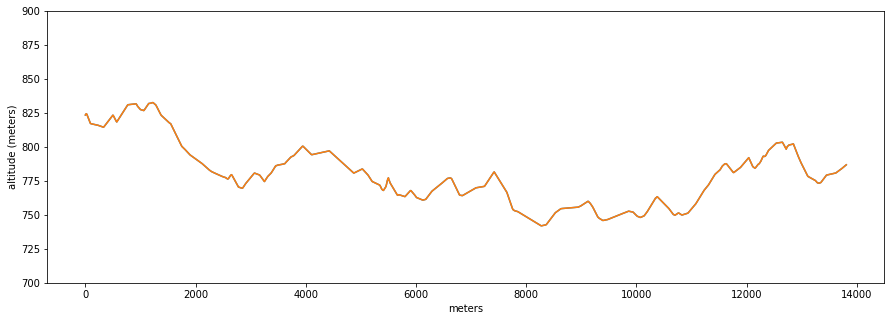

In [9]:
save_routes_json(route)
generate_images(route)

In [10]:
def process_maps_image(origin, dest, gender = 'm'):
    route = get_route_from_address(origin, dest)
    if route is not None:
        save_routes_json(route, gender)
        generate_images(route)

In [11]:
def process_route_adress():
    
    width = '70px'
    layout = widgets.Layout(width = '1000px')
    
    im = interact_manual(
        process_maps_image,
        origin = widgets.Text(description = 'Origin', style={'description_width': width}),
        dest = widgets.Text(description = 'Destination', style={'description_width': width}),
        gender = widgets.Dropdown(options = [('Male', 1), ('Female', 2)],
                                 description = 'Gender', style={'description_width': width}))
    im.widget.children[3].description = 'Process'

In [12]:
process_route_adress()

interactive(children=(Text(value='', description='Origin', style=DescriptionStyle(description_width='70px')), …